 # Ma511 FINAL PROJECT
 - BLIDI Nayel
 - DESCHAMPS Léo
 - POISSONNET Clément

 # *main.ipynb*
 This is the conclusion of the work carried out in *development.ipynb*, that synthetizes the best results acheived beforehand. As the reminder, here are all the tested architechture until now :
| Architecture | Epochs | Training Accuracy (%) | Testing Accuracy (%) |
|--------------|--------|-----------------------|----------------------|
| CNN          | 500    | 97 | 90 |
| CNN          | 1000   | **99** | **90** |
| LayeredNN    | 1000   | 100 | 88 |
| SparseLayeredNN | 1000 | 99 | 89 |
| VGG          | 100     | 79 | 78 |
| LSTM         | 1000   | 100 | 85 |

The convolutional network (CNN) shows the best generalization capacities, but because the multi-perceptron (LayeredNN) is crucial to a good classification output, we're going to try and extract the best of what these two have to offer in an hybrid version.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tifffile as tiff
import seaborn as sns

from tqdm import tqdm
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms

import os

main_path = os.path.abspath("") + "/"
s1_path = main_path + "s1_60m/"
s2_path = main_path + "s2_60m/"
labels_path = main_path + "labels/"
output_path = main_path

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data loading
The data has already been merged and sorted in *development.ipynb*, and is loaded from the *Datapoint.csv* file.

In [2]:
df_main = pd.read_csv(main_path+"Datapoints.csv")
# condition = df_main['Percentages'] >= 0.6
# df_main = df_main[condition]

# df_training = df_main[(df_main["Is_trainable"] == 1) & (df_main['Percentages'] >= 0.6)][["Filenames", "Class"]].dropna().reset_index(drop=True)
df_training = df_main[df_main["Is_trainable"] == 1][["Filenames", "Class"]].dropna().reset_index(drop=True)
display(df_training.describe().loc["count"])

df_testing = df_main[df_main["Is_trainable"] == 0][["Filenames", "Class"]].dropna().reset_index(drop=True)
display(df_testing.describe().loc["count"])


Class    45337.0
Name: count, dtype: float64

Class    5043.0
Name: count, dtype: float64

In [3]:
# Training examples (~7min first dataloading, 2min when re-executed)
X_train_s1 = [tiff.imread(s1_path + file) for file in df_training["Filenames"].values.tolist()]
X_train_s1 = np.stack(X_train_s1, dtype=np.float32)
X_train_s2 = [tiff.imread(s2_path + file) for file in df_training["Filenames"].values.tolist()]
X_train_s2 = np.stack(X_train_s2, dtype=np.float32)
X_train = np.concatenate([X_train_s1, X_train_s2], axis=3) # Concatenate alongside the soon-to-be in_channels dimension
# Dims are swapped in the default torch input order: (batch_size, in_channels, height, width)
X_train = np.transpose(X_train, (0, 3, 1, 2))
Y_train = np.array([df_training["Class"].to_numpy()], dtype=int).T
# One-hot encoding
Y_train = np.squeeze(np.eye(15)[Y_train])

# Testing examples (~1min first dataloading, 30sec when re-executed)
X_test_s1 = [tiff.imread(s1_path + file) for file in df_testing["Filenames"].tolist()]
X_test_s1 = np.stack(X_test_s1, dtype=np.float32)
X_test_s2 = [tiff.imread(s2_path + file) for file in df_testing["Filenames"].tolist()]
X_test_s2 = np.stack(X_test_s2, dtype=np.float32)
X_test = np.concatenate([X_test_s1, X_test_s2], axis=3) # Concatenate alongside the soon-to-be in_channels dimension
# Dims are swapped in the default torch input order: (batch_size, in_channels, height, width)
X_test = np.transpose(X_test, (0, 3, 1, 2))
Y_test = np.array([df_testing["Class"].to_numpy()], dtype=int).T
# One-hot encoding
Y_test = np.squeeze(np.eye(15)[Y_test])

print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(45337, 15, 6, 6) (5043, 15, 6, 6) (45337, 15) (5043, 15)


# Data preprocessing & augmentation
The data is augmented into two subdatasets:
- An augmented of the 45k training batch, where the images have a random probability of being flipped (horizontally/vertically) and rotated (90° of the previous output)
- The original training batch, simply normalized
- The testing dataset is normalized too  

We try to avoid any augmentation that could be result on a loss of data, considering how low the resolution already is.

In [4]:
train_dataset = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(Y_train).float())
test_dataset = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(Y_test).float())

mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

transform_pipeline = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=90),
    transforms.Normalize(mean=mean, std=std),
    # transforms.Resize((11, 11), interpolation=transforms.InterpolationMode.BILINEAR, antialias=True),
])

normalize_pipeline = transforms.Compose([
    transforms.Normalize(mean=mean, std=std),
    # transforms.Resize((11, 11), interpolation=transforms.InterpolationMode.BILINEAR, antialias=True),
])
train_dataset = [(normalize_pipeline(sample[0]).to(device), sample[1].to(device)) for sample in train_dataset]

# train_dataset = [(transform_pipeline(sample[0]), sample[1]) for sample in train_dataset]
# for k in range(1):
#     train_dataset = train_dataset + [(transform_pipeline(sample[0]), sample[1]) for sample in train_dataset]

test_dataset = [(normalize_pipeline(sample[0]).to(device), sample[1].to(device)) for sample in test_dataset]

print("Shape of one training example:", len(train_dataset), len(test_dataset), train_dataset[0][0].size(), train_dataset[0][1])

train_dataloader = DataLoader(train_dataset, batch_size=len(train_dataset)//16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=True)


Shape of one training example: 45337 5043 torch.Size([15, 6, 6]) tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')


# Model definition

In [28]:
class CNN(nn.Module):
    """
    A simple classifying CNN with a one hot encocoded output.
    \n
    Loss: CrossEntropyLoss
    Input dimensions: (batch, in_channels, height, width)
    \n
    Architechture:
        Conv2d(filters, kernel=(3,3), padding=1, stride=1) -> ReLU, Maxpool(2, 2) ->\n
        Conv2d(4*filters, kernel=(3,3), padding=1, stride=1) -> ReLU, Maxpool(2, 2) -> Flatten -> \n
        Linear(in_channels*filters*height*width, hidden_layers) -> ReLU -> Linear(hidden_layers, output_size) 
    \n

    Args:
        in_channels:
            Images: number for color channels. 1 for grayscale, 3 for RGB...
            Other: N/A
        filters: number of filters to apply and weighten (3x3 fixed kernel size)
        hidden_layers: classifying layers size/number of neurons
        output_size: number of labels, must be equal to the length of the one hot encoded target vector.
    """

    def __init__(self, in_channels=1, filters=16, hidden_layers=128, output_size=10, input_size=32, **kwargs):
        super(CNN, self).__init__()
        
        self.in_channels = in_channels
        self.outputsize = output_size
        self.filters = filters
        self.hidden_layers = hidden_layers

        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.batchnorm1 = nn.BatchNorm2d(num_features=filters)
        self.batchnorm2 = nn.BatchNorm2d(num_features=4*filters)
        self.batchnorm3 = nn.BatchNorm2d(num_features=8*filters)
        self.dropout = nn.Dropout(p=0.05)

        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=filters, kernel_size=3, padding=1, stride=1)
        self.conv2 = nn.Conv2d(in_channels=filters, out_channels=4*filters, kernel_size=3, padding=1, stride=1)
        self.conv3 = nn.Conv2d(in_channels=4*filters, out_channels=8*filters, kernel_size=3, padding=1, stride=1)

        self.linear1 = nn.Linear(self.num_flat_features(torch.ones(in_channels, filters, input_size, input_size)), self.hidden_layers)
        self.linear1 = nn.Linear(self.hidden_layers, self.hidden_layers)
        # self.linear2 = nn.Linear(self.hidden_layers, self.hidden_layers//4)
        self.linear3 = nn.Linear(self.hidden_layers, out_features=output_size)

    def forward(self, x):
        
        x = self.relu(self.conv1(x))
        x = self.maxpool(x)
        x = self.dropout(x)
        x = self.batchnorm1(x)
        x = self.relu(self.conv2(x))
        x = self.maxpool(x)
        x = self.dropout(x)
        x = self.batchnorm2(x)
        x = self.relu(self.conv3(x))
        x = self.batchnorm3(x)
        
        x = x.view(-1, self.num_flat_features(x))

        x = self.linear1(x)
        x = self.relu(x)
        # x = self.linear2(x)
        # x = self.relu(x)
        x = self.linear3(x)

        return x

    #Flattens along dim>=1
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

model = CNN(in_channels=15, filters=2*16, hidden_layers=256, output_size=15, input_size=6)
model_name = "CNN"
model.to(device)

print(model)

CNN(
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (batchnorm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.05, inplace=False)
  (conv1): Conv2d(15, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (linear1): Linear(in_features=256, out_features=256, bias=True)
  (linear3): Linear(in_features=256, out_features=15, bias=True)
)


# Model training

100%|██████████| 102/102 [07:14<00:00,  4.26s/it]


Finished training, CNN_102e.pth saved at epoch 27
Final loss: 1.7134830951690674


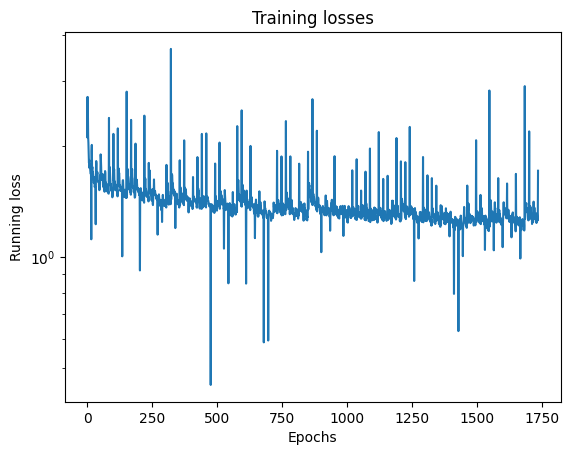

In [29]:

criterion = nn.CrossEntropyLoss()
lr = 0.001

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
model.train() 

running_loss = 0.0
losses_list = []
best_loss = 1e12
num_epochs = 102
for epoch in tqdm(range(num_epochs)):

    for inputs, targets in train_dataloader:

        optimizer.zero_grad()  
        outputs = model(inputs)  

        loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        losses_list.append(loss.item())

        if loss.item() < best_loss:
            loss_epoch = epoch
            best_loss = loss.item()
            torch.save(model, f"{output_path}/{model_name}_{num_epochs}e.pth")

print(f"Finished training, {model_name}_{num_epochs}e.pth saved at epoch {loss_epoch}")
print(f"Final loss: {loss.item()}")

plt.semilogy(losses_list)
plt.title("Training losses")
plt.xlabel("Epochs")
plt.ylabel("Running loss")
plt.savefig(f"{output_path}/Loss_{model_name}_{num_epochs}e.png")


# Model testing

In [30]:
model_name = "CNN_102e"

model = torch.load(f"{output_path}/{model_name}.pth")
model.to("cuda")

model.eval()
with torch.no_grad():
    for test_features, test_labels in test_dataloader: # Tests real accuracy

        test_labels = torch.argmax(test_labels, dim=1).cpu().numpy()

        test_predicted = torch.argmax(model(test_features), dim=1).cpu().numpy()

        test_success = np.sum(np.equal(test_predicted, test_labels))
        print(f"testing accuracy: {test_success/test_predicted.shape[-1]:.4f}")

    for train_features, train_labels in train_dataloader: # Tests overfitting

        train_labels = torch.argmax(train_labels, dim=1).cpu().numpy()

        train_predicted = torch.argmax(model(train_features), dim=1).cpu().numpy()
        train_success = np.sum(np.equal(train_predicted, train_labels))
        print(f"training accuracy: {train_success/train_predicted.shape[-1]:4f}")


testing accuracy: 0.5532
training accuracy: 0.574656
training accuracy: 0.574656
training accuracy: 0.579245
training accuracy: 0.570773
training accuracy: 0.576774
training accuracy: 0.570420
training accuracy: 0.552418
training accuracy: 0.578539
training accuracy: 0.567949
training accuracy: 0.558066
training accuracy: 0.589834
training accuracy: 0.588775
training accuracy: 0.574656
training accuracy: 0.563360
training accuracy: 0.578539
training accuracy: 0.579245
training accuracy: 0.555556


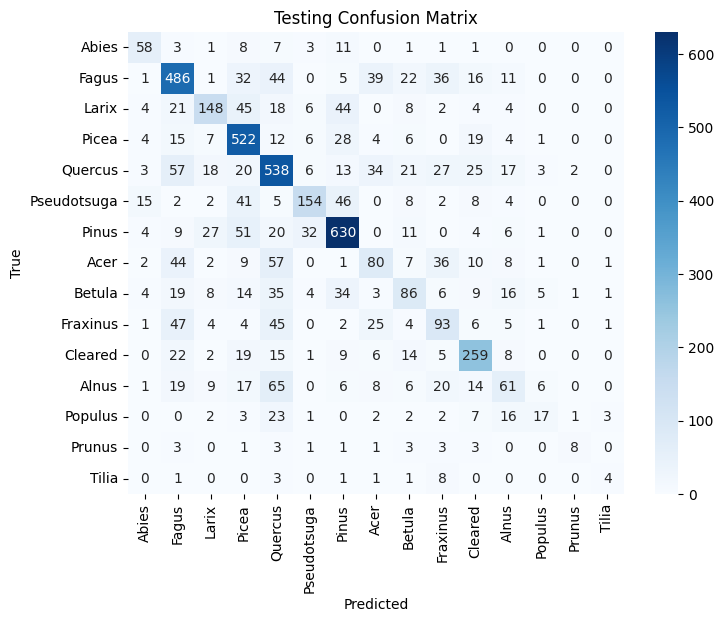

In [21]:
cm_test = confusion_matrix(test_labels, test_predicted)
cm_train = confusion_matrix(train_labels, train_predicted)


categories = ['Abies', 'Fagus', 'Larix', 
              'Picea', 'Quercus', 'Pseudotsuga', 
              'Pinus', 'Acer', 'Betula', 'Fraxinus', 
              'Cleared', 'Alnus', 'Populus', 'Prunus', 'Tilia']

plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues", xticklabels=categories, yticklabels=categories)
plt.title("Testing Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


| Dataset | Filters | Linear layers neurons | Batchnorm | Dropout | Epochs | Training Accuracy (%) | Testing Accuracy (%) |
|---------|---------|-----------------------|-----------|---------|--------|-----------------------|----------------------|
|Augmented once | 16 | 576                  | 0         | 0       | 100    | 57 | 55 |
|Augmented once | 16 | 576                  | 0         | 0       | 500    | 73 | 60 |
|Augmented once | 16 | 576 (3 layers)       | 0         | 0       | 500 | 64 | 59 |
|Augmented once | 16 | 576                  | 2 layers  | 0       | 500 | 96 | 54 |
|Augmented once | 16 | 576                  | 2 layers  | 0.2       | 500 | 74 | 60 |
|Augmented once | 16 | 576                  | 2 layers  | 0.1       | 500 | 81 | 59 |
|Augmented once | 16 | 576                  | 0         | 0       | 1000   | 71 | 59 |
|Augmented once | 32 | 1152                 | 0         | 0       | 500    | 34 | 33 |

<br>

| Dataset | Filters | Linear layers neurons | Batchnorm | Dropout | Epochs | Training Accuracy (%) | Testing Accuracy (%) |
|---------|---------|-----------------------|-----------|---------|--------|-----------------------|----------------------|
|Augmented once, pure | 16 | 576            | 2 layers  | 0       | 500 | 97 | 54 |
|Augmented once, pure | 16 | 576            | 2 layers  | 0.1       | 500 | 85 | 59 |
|Augmented twice, pure | 16 | 576                  | 2 layers  | 0.1       | 500 | 51 | 60 |
|Augmented twice, pure | 16 | 576                  | 2 layers  | 0       | 500 |  |  |

<br>
 
| Dataset | Filters | Linear layers | Batchnorm | Dropout | Epochs | Training Accuracy (%) | Testing Accuracy (%) |
|---------|---------|---------------|-----------|---------|--------|-----------------------|----------------------|
|Normalized, pure (batch//1) | 16    | 576           |  2 layers | 0          | 500 | 99 | 56 |
|Normalized, pure (batch//1) | 16 | 576 (2 layers)       | 2 layers  | 0.20       | 500 | 85 | 60 |
|Normalized, pure (batch//1) | 32 | 256                  | 2 layers  | 0.05       | 500    | **99** | 60 |
|Normalized, pure (batch//1) | 32 | 256                  | 2 layers  | 0.15       | 500    | 99 | 60 |
|Normalized, pure (batch//1) | 32 | 256                  | 2 layers  | 0.25       | 500    | **98** | **61** |
|Normalized, impure (batch//1)| 32 | 256                  | 2 layers  | 0.25       | 500    | 97 | 61 |
|Normalized, impure (batch//16)| 32 | 256                  | 2 layers  | 0.25       | 500    | 72 | **62** |
|Normalized, impure (batch//16)| 32 | 256                  | 2 layers  | 0.10       | 500    | 83 | 61 |
|Normalized, impure (batch//16)| 32 | 256                  | 2 layers  | 0.05       | 1000    |  |  |